## SOT using L2 from scratch

This code retrieves a surface map from reflection integrated light curve of an Earth analog.

See 
- Kawahara & Fujii 2010 (http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1004.5152)
- Kawahara & Fujii 2011 (http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1106.0136)
- Fujii & Kawahara 2012 (http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1204.3504)

for more details.  

The core module of the Tikhonov regularization is from 
- pinvprob (https://github.com/HajimeKawahara/pinvprob).

You need Healpy. Install by 

``pip install healpy``

for instance.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import healpy as hp
import pylab 
import matplotlib.pyplot as plt
import time

In [3]:
#vectors and weight
def comp_omega(nside):
    omega=[]    
    npix=hp.nside2npix(nside)
    print("npix=",npix)
    for ipix in range(0,npix):
        theta,phi=hp.pix2ang(nside,ipix)
        omega.append([theta,phi])            
    return np.array(omega)

def uniteO(inc,Thetaeq):
    #(3)
    eO=np.array([np.sin(inc)*np.cos(Thetaeq),-np.sin(inc)*np.sin(Thetaeq),np.cos(inc)])
    return eO

def uniteS(Thetaeq,Thetav):
    #(3,nsamp)
    eS=np.array([np.cos(Thetav-Thetaeq),np.sin(Thetav-Thetaeq),np.zeros(len(Thetav))])
    return eS

def uniteR(zeta,Phiv,omega):
    #(3,nsamp,npix)    
    np.array([Phiv]).T
    costheta=np.cos(omega[:,0])
    sintheta=np.sin(omega[:,0])
    cosphiPhi=np.cos(omega[:,1]+np.array([Phiv]).T)
    sinphiPhi=np.sin(omega[:,1]+np.array([Phiv]).T)
    x=cosphiPhi*sintheta
    y=np.cos(zeta)*sinphiPhi*sintheta+np.sin(zeta)*costheta
    z=-np.sin(zeta)*sinphiPhi*sintheta+np.cos(zeta)*costheta
    eR=np.array([x,y,z])

    return eR

def comp_weight(nside,zeta,inc,Thetaeq,Thetav,Phiv):
    omega=comp_omega(nside)
    eO=uniteO(inc,Thetaeq)
    eS=uniteS(Thetaeq,Thetav)
    eR=uniteR(zeta,Phiv,omega)
    WV=[]
    for ir in range(0, np.shape(eS)[1]):
        ele=np.dot(eR[:,ir,:].T,eO)
        WV.append(ele)
    WV=np.array(WV)
    mask=(WV<0.0)
    WV[mask]=0.0
    WI=[]
    for ir in range(0, np.shape(eS)[1]):
        ele=np.dot(eR[:,ir,:].T,eS[:,ir])
        WI.append(ele)
    WI=np.array(WI)
    mask=(WI<0.0)
    WI[mask]=0.0

    return WI,WV

In [4]:
#set geometry
inc=0.0
Thetaeq=np.pi
zeta=np.pi/3.0
                                                                                                
Pspin=23.9344699/24.0 #Pspin: a sidereal day                                                                                                                                                                                                               
wspin=2*np.pi/Pspin                                                                                                          
#Porb=365.242190402                                            
Porb=40.0
worb=2*np.pi/Porb                                                                                                                
N=1024
obst=np.linspace(0.0,Porb,N)

NSIDE = 16
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


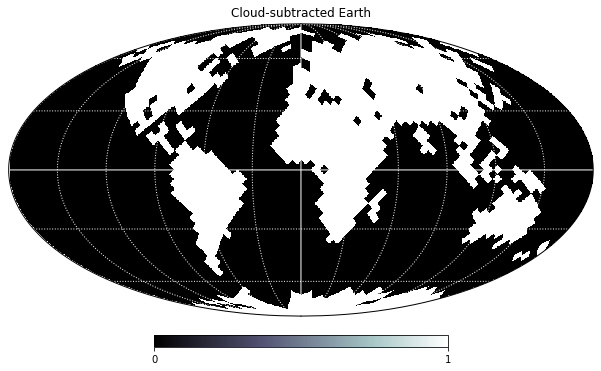

In [5]:
# test map
nside=16
mmap=hp.read_map("../data/mockalbedo16.fits")
mask=(mmap>0.0)
mmap[mask]=1.0
hp.mollview(mmap, title="Cloud-subtracted Earth",flip="geo",cmap=plt.cm.bone,min=0,max=1)
#hp.mollview(Kvolall,title="Kvol",flip="geo",cmap=plt.cm.Spectral,min=-0.3,max=0.3)
hp.graticule(color="white");
M=len(mmap)

In [11]:
Thetav=worb*obst
Phiv=np.mod(wspin*obst,2*np.pi)

WI,WV=comp_weight(nside,zeta,inc,Thetaeq,Thetav,Phiv) #(1)

#If you want to use mocklc module in sot package, uncomment these two lines instead of the line (1).
#import mocklc
#WI,WV=mocklc.comp_weight(nside,zeta,inc,Thetaeq,Thetav,Phiv)

W=WV[:,:]*WI[:,:]
lc=np.dot(W,mmap)

sigma=np.mean(lc)*0.03
noise=np.random.normal(0.0,sigma,len(lc))
lc=lc+noise

('npix=', 3072)
Shopes of eO, eS, eR
(3,) (3, 1024) (3, 1024, 3072)


No handles with labels found to put in legend.


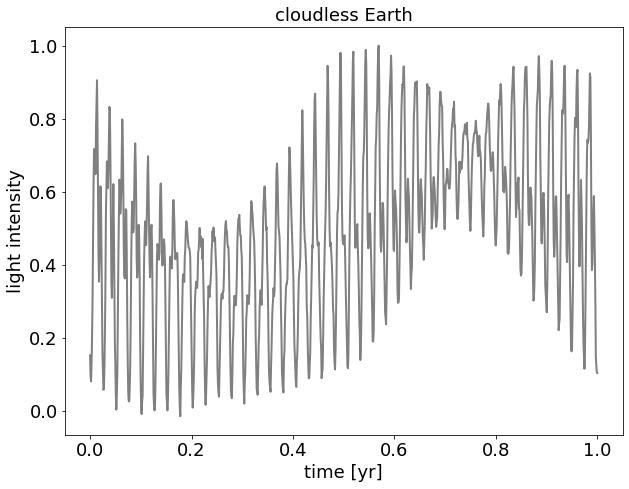

In [12]:
fig= plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
ax.plot(obst/obst[-1],lc/np.max(lc),lw=2,color="gray")
plt.legend(loc="upper right",prop={'size':11},frameon=False)
plt.tick_params(labelsize=18)
plt.ylabel("light intensity",fontsize=18)
plt.xlabel("time [yr]",fontsize=18)
plt.title("cloudless Earth",fontsize=18)
plt.savefig("sotlc.png", bbox_inches="tight", pad_inches=0.0)
plt.show()


In [9]:
#Tikhonov regularization

def tikhonov_regularization(Dm,Ao,Smprior,U,VT,S,lambdatik,p=None):
    import numpy as np
    #should be np.array
    sumphi=0.0
    dxidlam=0.0

    Ndata=len(Ao)
    Mmodel=len(Smprior)
    Sm=np.zeros(Mmodel) 

    dv=[]
    for idata in range(0,Ndata):
        dv.append(Ao[idata]-np.inner(Dm[idata,:],Smprior))

    if p is None:
        p=min(Ndata,Mmodel)
    
    for i in range(0,p):
           phii=(S[i]**2/(S[i]**2+lambdatik**2))
           phij=(S[i]/(S[i]**2+lambdatik**2))
           dxidlam=dxidlam+(1.0-phii)*(phij**2)*(np.inner(U[:,i],dv)**2)
           Sm=Sm+phij*np.inner(U[:,i],dv)*VT[i,:]
           
    dxidlam=-4.0*dxidlam/lambdatik

    Sm=Sm+Smprior    
    Aoest=np.dot(Dm,Sm)
    residual=np.linalg.norm(Ao-Aoest)
    modelnorm=np.linalg.norm(Sm-Smprior)

    lam2=lambdatik**2
    rho=residual*residual
    xi=modelnorm*modelnorm
    curv_lcurve=-2.0*xi*rho/dxidlam*(lam2*dxidlam*rho+2.0*lambdatik*xi*rho+lam2*lam2*xi*dxidlam)/((lam2*lam2*xi*xi+rho*rho)**1.5)

    return Sm,Aoest,residual,modelnorm,curv_lcurve

def NGIM_regularization(Dm,Ao,Smprior,U,VT,S,lim):
    import numpy as np
    #should be np.array

    p = np.sum(S>lim)
    print("NGIM/TSVD: we regard values below ",lim," as zero.")
    print("p = ", p)
    sumphi=0.0

    Ndata=len(Ao)
    Mmodel=len(Smprior)
    Sm=np.zeros(Mmodel) 

    dv=[]
    for idata in range(0,Ndata):
        dv.append(Ao[idata]-np.inner(Dm[idata,:],Smprior))

    for i in range(0,p):
        phij=(1.0/S[i])
        Sm=Sm+phij*np.inner(U[:,i],dv)*VT[i,:]

    Sm=Sm+Smprior    
    Aoest=np.dot(Dm,Sm)
    residual=np.linalg.norm(Ao-Aoest)
    modelnorm=np.linalg.norm(Sm-Smprior)

    return Sm,Aoest,residual,modelnorm

In [9]:
mprior=np.zeros(M) #prior
lamb=0.1 # regularization parameter
zetax=zeta
start = time.time()
U,S,VT=np.linalg.svd(WV[:,:]*WI[:,:])
elapsed_time = time.time() - start                                                                                      
print (("elapsed_time (SVD) :{0}".format(elapsed_time)) + "[sec]")  

elapsed_time (SVD) :3.539905071258545[sec]


In [10]:
nlcurve=30
lmin=0.1
lmax=100.0
lamseq=np.logspace(np.log10(lmin),np.log10(lmax),num=nlcurve)

In [11]:
modelnormseq=[]
residualseq=[]
curveseq=[]

for lamb in lamseq:
    mest,dpre,residual,modelnorm,curv_lcurve=tikhonov_regularization(W,lc,mprior,U,VT,S,lamb)
    modelnormseq.append(modelnorm)
    residualseq.append(residual)
    curveseq.append(curv_lcurve)
    print(lamb, curv_lcurve)

residualseq=np.array(residualseq)
modelnormseq=np.array(modelnormseq)
imax=np.argmax(curveseq)
lamb=lamseq[imax]
print("Best lambda=",lamb)

0.1 -0.0752028454623
0.126896100317 -0.0640339317535
0.161026202756 -0.0553415857901
0.204335971786 -0.0455303108133
0.25929437974 -0.0314593838718
0.329034456231 -0.00942702473433
0.417531893656 0.0283654556594
0.529831690628 0.101992961796
0.67233575365 0.263737085045
0.853167852417 0.648330964823
1.08263673387 1.57665905777
1.37382379588 3.60514326678
1.7433288222 6.82921729311
2.21221629107 9.13116223872
2.80721620394 7.93111278579
3.56224789026 4.79347308165
4.52035365636 2.3451365284
5.73615251045 1.04988274063
7.27895384398 0.45073771695
9.23670857187 0.179211055635
11.7210229753 0.0530915435134
14.8735210729 -0.0106384502686
18.8739182214 -0.0505943519655
23.9502661999 -0.0858652392869
30.3919538231 -0.128575092191
38.5662042116 -0.190501192271
48.9390091848 -0.284530155638
62.1016941892 -0.41823138561
78.8046281567 -0.57081116765
100.0 -0.663987672268
Best lambda= 2.21221629107


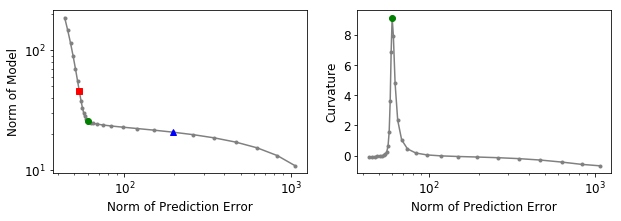

In [12]:
#define small and large lambda cases
ismall=imax-7 
ilarge=imax+10

#plot a L-curve
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(121)
pylab.xscale('log')
pylab.yscale('log')
pylab.ylabel("Norm of Model",fontsize=12)
pylab.xlabel("Norm of Prediction Error",fontsize=12)
ax.plot(residualseq,modelnormseq,marker=".",c="gray")
ax.plot([residualseq[imax]],[modelnormseq[imax]],marker="o",c="green")
ax.plot([residualseq[ismall]],[modelnormseq[ismall]],marker="s",c="red")
ax.plot([residualseq[ilarge]],[modelnormseq[ilarge]],marker="^",c="blue")
plt.tick_params(labelsize=12)
ax2 = fig.add_subplot(122)
pylab.xscale('log')
pylab.ylabel("Curvature",fontsize=12)
pylab.xlabel("Norm of Prediction Error",fontsize=12)
ax2.plot(residualseq,curveseq,marker=".",c="gray")
ax2.plot([residualseq[imax]],[curveseq[imax]],marker="o",c="green")
plt.tick_params(labelsize=12)
plt.savefig("lcurve.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()

In [13]:
#getting maps!
mest_lbest,dpre,residual,modelnorm,curv_lcurve=tikhonov_regularization(W,lc,mprior,U,VT,S,lamb)
mest_ls,dpre,residual,modelnorm,curv_lcurve=tikhonov_regularization(W,lc,mprior,U,VT,S,lamseq[ismall])
mest_ll,dpre,residual,modelnorm,curv_lcurve=tikhonov_regularization(W,lc,mprior,U,VT,S,lamseq[ilarge])

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


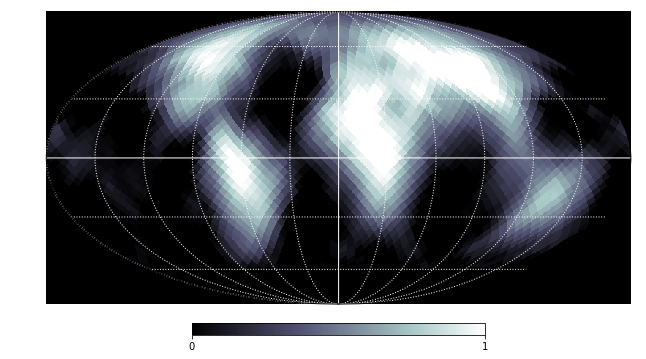

In [14]:
#best map
hp.mollview(mest_lbest, title="",flip="geo",cmap=plt.cm.bone,min=0,max=1.0)
hp.graticule(color="white");

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


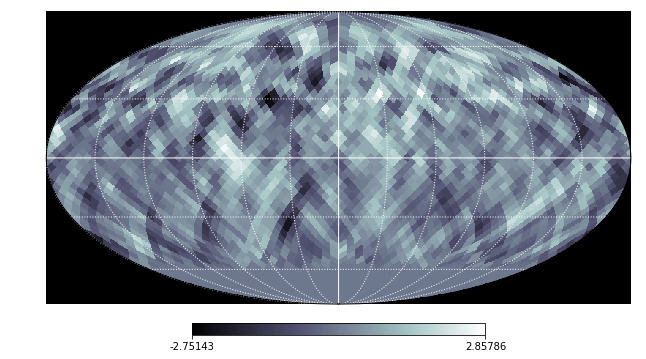

In [15]:
# too small lambda
hp.mollview(mest_ls, title="",flip="geo",cmap=plt.cm.bone)
hp.graticule(color="white");

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


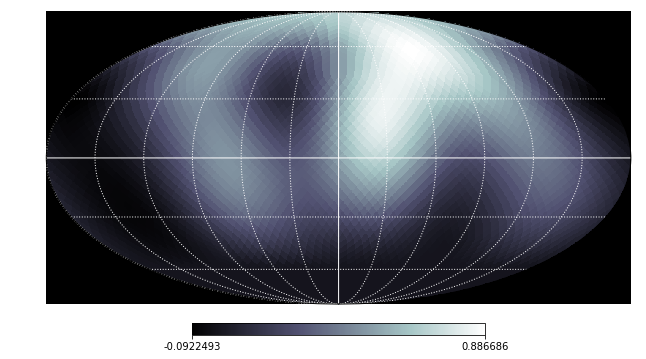

In [16]:
# too large lambda
hp.mollview(mest_ll, title="",flip="geo",cmap=plt.cm.bone)
hp.graticule(color="white");